In [13]:
%reload_ext autoreload
%autoreload 2

from utils import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer
from sklearn.model_selection import train_test_split
from time import time
from tqdm import tqdm

In [14]:
df_test = read_data('data/test', 'test')

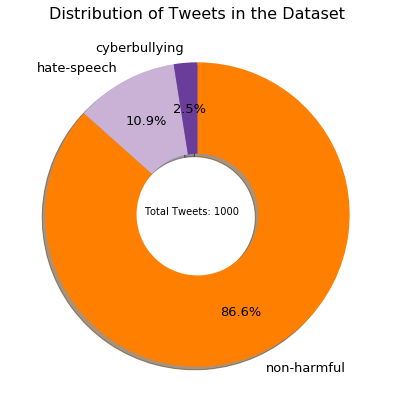

In [15]:
plt.figure(figsize = (7,7))
sorted_counts = df_test['label_text'].value_counts()
plt.pie(sorted_counts, labels = sorted_counts.index, startangle = 90, counterclock = False, wedgeprops = {'width' : 0.6},
       autopct='%1.1f%%', pctdistance = 0.7, textprops = {'color': 'black', 'fontsize' : 13}, shadow = True,
        colors = sns.color_palette("Paired")[7:])
plt.text(x = -0.35, y = 0, s = 'Total Tweets: {}'.format(df_test.shape[0]))
plt.title('Distribution of Tweets in the Dataset', fontsize = 16);

In [16]:
X_test, y_test = df_test[['text']], df_test[['label']]

In [17]:
from utils import *
from polishbert import *

# load embeddings and model

In [18]:
get_embeddings, tokenizer = load_embeddings(model_dir = "roberta_base_transformers")

In [19]:
from model import *

In [20]:
def load_trained_model(net, model_path, device):
    net.load_state_dict(
            torch.load(model_path, map_location=device))
    print("[*] Loaded weights from {}".format(model_path))
        
    net = net.to(device)
    net.eval()
    return net

In [22]:
embed_num = 30
embed_dim = 768
class_num = 3
kernel_num = 3
kernel_sizes = [2, 3, 4]
dropout = 0.5
kernel_num = 3
kernel_sizes = [2, 3, 4]
dropout = 0.3
static = True
model = KimCNN(
    embed_num=embed_num,
    embed_dim=embed_dim,
    class_num=class_num,
    kernel_num=kernel_num,
    kernel_sizes=kernel_sizes,
    dropout=dropout,
    static=static,
)

In [23]:
model = load_trained_model(model, 'models/emb_roberta_kimcnn.pth', 'cpu')

[*] Loaded weights from models/emb_roberta_kimcnn.pth


# predictions

In [86]:
#on cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [85]:
y_preds = []
model.eval() 
with torch.no_grad():
    for sentence in tqdm(X_test['text']):
        sentence = clean_tweet(sentence)
        test_indices = tokenize_and_pad_text(pd.DataFrame([sentence])[0], 30, tokenizer)
        embeddings = get_embeddings(test_indices)[0]
        y_pred = model(embeddings)
        y_pred = torch.argmax(y_pred, dim=1)
        y_preds.extend(y_pred.detach().numpy().tolist())
            #clean
y_preds_np = np.array(y_preds)

100%|██████████| 1000/1000 [01:14<00:00, 13.34it/s]


In [91]:
performance_per_second = 74/1000 # 1000 examples, 1min14 seconds
performance_per_second

0.074

## Solution runs on CPU at 74 milliseconds per observation

In [87]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer

In [88]:
f1_score(np.array(y_test), y_preds_np, average='macro')

0.5298588387790265

In [89]:
f1_score(np.array(y_test), y_preds_np, average='micro')

0.891